### ---------------------------------------------------
Analysis of the Titanic Dataset from Kaggle, encompassing passenger
information for 891 of 2224 passengers and crew on board.

Created by Yang Dai, 16 Dec 1.
### ---------------------------------------------------

This report analyzes the survival metrics of slightly under one half of the passengers onboard the Titanic.  For the passengers recorded, the data recorded includes: names, passenger class, sex, age, sibling/spouse counts, parent/child counts, ticket number, fare, cabin, and port of embarkment.

Through various visual categorical representations and statistical summaries, this report will attempt to identify interesting survival trends, in particular those associated with the passengers grouped by sibling/spouse count.  It will also evaluate whether married couples held any survival advantage over comparable peer groups.

In [1]:
# import all libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

In [2]:
# Import data
titanic_df = pd.read_csv('titanic_data.csv')
print titanic_df.head() #check data import

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


Looking at the Cabin listing, it's clear that this dataset is not complete for every passenger listed.  Performing a count of each index will give a clearer picture of which data is incomplete.

In [3]:
# Print number of data entries / total passengers recorded in dataset
totalpass = titanic_df['PassengerId'].count()
print str(totalpass) + " Passengers in Dataset"
print '\nData Completeness (%):'
print titanic_df.count()/totalpass * 100

891 Passengers in Dataset

Data Completeness (%):
PassengerId    100.000000
Survived       100.000000
Pclass         100.000000
Name           100.000000
Sex            100.000000
Age             80.134680
SibSp          100.000000
Parch          100.000000
Ticket         100.000000
Fare           100.000000
Cabin           22.895623
Embarked        99.775533
dtype: float64


For the 891 passengers recorded, most of the data is fairly complete, with the exception of Cabin.  Since Cabin is only populated for less than a quarter of the passengers, it will be ignored in this analysis.  To not overwhelm the scope of this analysis, Age and Embarked will be excluded as well.

The variables represented in discrete values are Pclass, Sex, SibSp, and Parch.  Visually representing the survivor ratios grouping by each discrete will help identify areas of interest.

In [4]:
def surv_by_grp(df,varlist):
    # runs groupby on df for each variable on the varlist to tally survivors,
    # total passengers, and survival rates for each value of the variables listed
    
    grouped_surv_totals = pd.DataFrame()

    for disvar in varlist: #loop through each variable
        grouped = pd.DataFrame() #temporary dataframe
    
        #total survivors
        survivors = df.groupby([disvar], as_index=False)['Survived'].sum()
        #store discrete variable+value
        grouped['Variable'] = disvar + "_" + survivors[disvar].astype(str)
        #store survivors
        grouped['Survived'] = survivors['Survived'] 
        #store total passengers
        grouped['Total'] = df.groupby([disvar], 
                            as_index=False)['Survived'].count()['Survived'] 
        #store survival rate
        grouped['Survival_Rate'] = grouped['Survived'] / grouped['Total']
    
        grouped_surv_totals = grouped_surv_totals.append(grouped, ignore_index=True)
    
    return grouped_surv_totals

In [5]:
# generate survivor data for the discrete variables

discretevar = ['Pclass','Sex','SibSp','Parch']
grouped_discretevar = surv_by_grp(titanic_df, discretevar)

#print grouped_surv_totals #check function

In [6]:
def plot_grp_surv(df):
    # plot total passengers in each group
    sns.set_color_codes("pastel")
    ax = sns.barplot(x="Total", y="Variable", data=df, label="Total", color="b")

    # plot survivors in each group
    sns.set_color_codes("muted")
    ax = sns.barplot(x="Survived", y="Variable", data=df, label="Survived", 
                     color="b")

    # add a legend and labels
    ax.legend(ncol=2, loc="lower right", frameon=True)
    ax.set(ylabel="Variable_Values", xlabel="Passengers", 
          title = "Survivors and Total Passengers by Group")

    # add survival percentages to each bar
    i = 0
    for p in ax.patches:
        if i < len(ax.patches)/2:
            ax.text(p.get_width()+5, p.get_y()+.75, 
                '%1.0f'%(df['Survival_Rate'][i]*100)+"%")
        i += 1

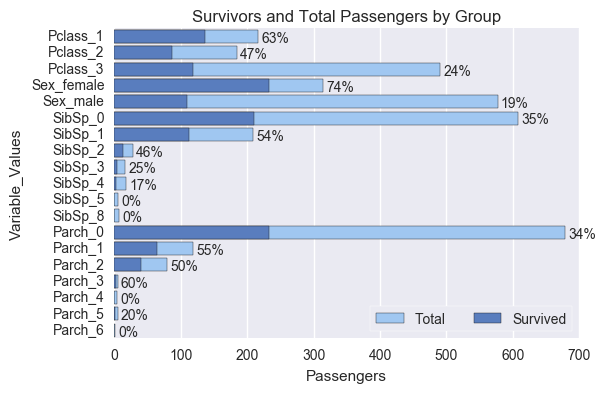

In [7]:
# plot discrete groupby data
plot_grp_surv(grouped_discretevar)

From this plot, it's evident that the following groups had the best survival rates - 
    
    Passenger Class: first
    Sex: female
    Sibling/Spouse Count: 1
    Parent/Child Count: 3

The passenger class and sex results are not surprising.  The first class passengers likely had priority access to the lifeboats, and it's well known that women and children had precedence for lifeboat spots, so the female survival rate being more than three times the male survival rate is as expected.

There is no obvious explanation for the Sibling/Spouse and Parent/Child results.  The Sibling/Spouse groupings have a better distribution of passengers than the Parent/Child groups, so this report will dive into the Sibling/Spouse groups for a more robust study.

- Did the Sib/Sp = 1 group have a large percentage of first class passengers and females, skewing the survival rate upward?
- Maybe the Sib/Sp = 1 group primarily consisted of married couples who were more motivated to survive together?
- Did the men in the Sib/Sp = 1 group have a higher survival rate than the mean male survival rate?

In [8]:
# pick color palette for pie charts
#sns.choose_colorbrewer_palette('q')

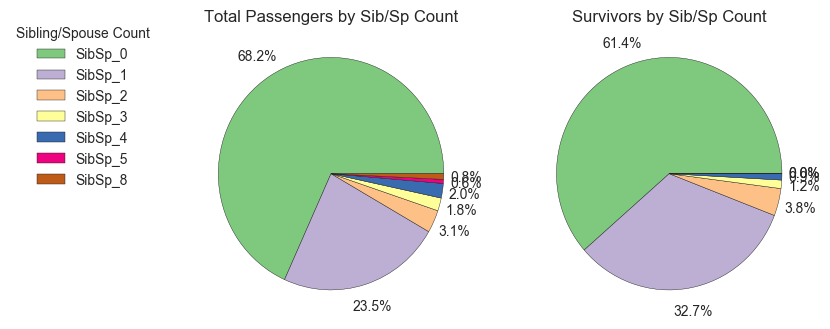

In [27]:
# graphically represent the survivors/total passengers grouped by Sib/Sp only

# group entire dataset by SibSp only
grouped_sibsp = surv_by_grp(titanic_df, ['SibSp'])

# generate pie charts of total passengers and survivors by SibSp count
ax1, ax2 = grouped_sibsp.plot(y = ['Total','Survived'], labels=None, 
                              kind='pie', autopct='%1.1f%%', pctdistance=1.2,
                              colors=sns.color_palette("Accent", 7), 
                              subplots=True, figsize=(8, 3.75))
ax1.title.set_text('Total Passengers by Sib/Sp Count')
ax2.title.set_text('Survivors by Sib/Sp Count')
ax2.legend(bbox_to_anchor=(-1.3, 1.05), labels = grouped_sibsp['Variable'], title = "Sibling/Spouse Count")
ax1.set_ylabel('')
ax2.set_ylabel('')

These pie charts better illustrate how much the Sib/Sp = 1 group outperformed the others - although this group consisted of a little less than a quarter of the total passengers on board, they made up almost one third of the total survivors.  The slices for total passengers with sibsp > 3 are very small, and it appears very few of them survived.

Taking a closer look at whether the survival rates grouped by sibsp count show different trends by gender or class -

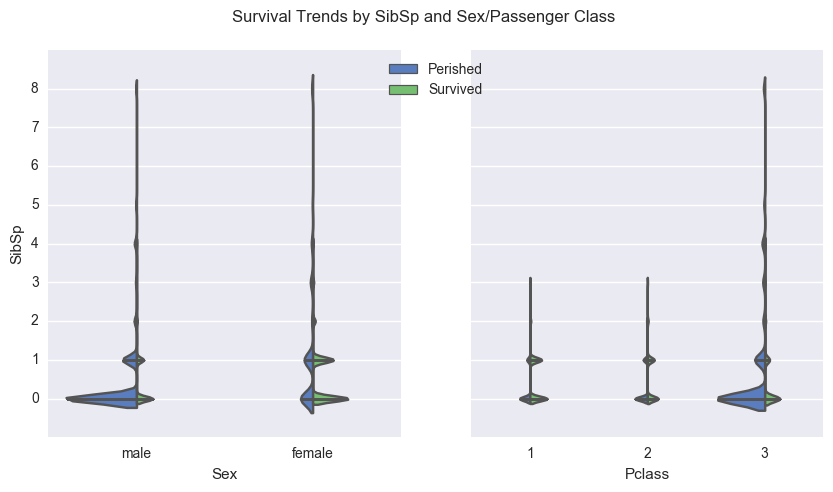

In [10]:
# plot sex and passenger class against sibsp, split violin plots on 'Survived'

fig, (ax3, ax4) = plt.subplots(1,2,sharey=True,figsize=(10,5)) #create 1x2 subplots
sns.violinplot(x="Sex", y="SibSp", hue="Survived", data=titanic_df, ax = ax3, scale='count', 
               scale_hue=False, palette="muted", split=True, inner="stick", bw=.1)
sns.violinplot(x="Pclass", y="SibSp", hue="Survived", data=titanic_df, ax = ax4, scale='count', 
               scale_hue=False, palette="muted", split=True, inner="stick", bw=.1)
handles, labels = ax4.get_legend_handles_labels()
ax4.legend([handles[0], handles[1]], ["Perished", "Survived"], bbox_to_anchor=(0.07, 1))
ax3.legend_.remove()
ax3.set_yticks(range(0,9))
ax4.set_ylabel("")
plt.suptitle('Survival Trends by SibSp and Sex/Passenger Class', fontsize=12)

This violin plot is a good visualization of the size of each group and the trends across the Sib/Sp counts. There are noticeably more men and third class passengers onboard, and these two groups have a larger proportion of perished passengers.

The trends on passenger class are as expected - the third class passengers had higher mortality across the board.

The plot for sex on the other hand seems to show opposite trends for males and females, moving from sibsp = 0 to sibsp = 1.  The males seem to have a slightly higher survival rate at sibsp = 1, whereas the women seem to have a slightly higher rate at sibsp = 0.  These graphs are too high level to confirm, so this will require further investigation.

In [11]:
def slicedf(df,var,value):
    #extracts subset of df where var == value
    return df[df[var]==value]

In [12]:
def analyzevar(df,var):
    #returns survival rates grouped by var
    vargrp = df.groupby([var],as_index=False)['Survived'].mean()
    vargrp = vargrp.rename(columns = {'Survived':'Survival Rate'})
    
    return vargrp

In [13]:
# analyze female survival rates grouped by sibling/spouse count
fem_tit_df = slicedf(titanic_df,'Sex','female')
fem_sibsp = analyzevar(fem_tit_df,'SibSp')
#print "Female Survival Rates by Sibling/Spouse Count: \n"
#print fem_sibsp

In [14]:
# analyze male survival rates grouped by sibling/spouse count
male_tit_df = slicedf(titanic_df,'Sex','male')
male_sibsp = analyzevar(male_tit_df,'SibSp')
#print "Male Survival Rates by Sibling/Spouse Count: \n" 
#print male_sibsp

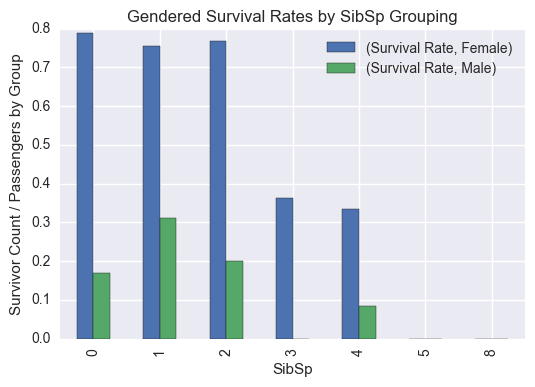

In [15]:
# plot survivability by gender and sibsp count
fem_sibsp['Gender'] = 'Female'
male_sibsp['Gender'] = 'Male'

sibspdf = pd.concat([fem_sibsp,male_sibsp],keys=['Female','Male'])
sibsp_group = sibspdf.groupby(['SibSp','Gender'])

sibsp_group.sum().unstack('Gender').plot(kind='bar')
plt.ylabel('Survivor Count / Passengers by Group')
plt.legend(title='')
plt.title('Gendered Survival Rates by SibSp Grouping')

Fewer siblings/spouses onboard appears to be a distinct advantage for survival, especially for males, where the survival rate does noticeably peak at one sibling/spouse, confirming the earlier observations from the violin plots.  Perhaps this group mostly consists of males traveling with their spouses, giving them a better chance of securing a position on a life boat?

Because the female passengers are listed under their husbands' names in the database, the married couples can be easily identified.

In [16]:
# split out the males with exactly one sibling/spouse
male_onesibsp = slicedf(male_tit_df,'SibSp',1)
#print male_onesibsp.head() #check the subset

In [17]:
# generate a list of male names without honorifics

# split off the last names using the comma delineator
malesplitname = male_onesibsp['Name'].str.split(', ')

# extract the last names and first names
male_names = [[name[0],name[1].split('. ')[1]] for name in malesplitname]

#print male_names

In [18]:
# find married females by checking whether the names contain "Mrs"
marriedfem = fem_tit_df[fem_tit_df['Name'].str.contains('Mrs.')]

# filter out those with zero SibSp on the ship
marriedfem = marriedfem[marriedfem['SibSp'] > 0]

#print marriedfem.head()

In [19]:
def searchspouse(df,names):
    '''Search df for name matches and add a "Spouse" boolean Series 
            to the df to identify whether the spouse is present.
    Return a tuple of the modified df and the list of matching names.'''

    df.loc[:,'Spouse'] = False #initialize Spouse series to all False
    match_names = []

    for index, record in df.iterrows(): #for each record in df
        for m_name in names: #loop through all requested names
            if m_name[0] in record['Name'] and m_name[1] in record['Name']:
                df.loc[index,'Spouse'] = True
                match_names.append(m_name)
    
    return df, match_names

In [20]:
# search married women for male names
marriedfem_sp, match_names = searchspouse(marriedfem,male_names)

In [28]:
# identify the husbands using the matched names from the married women
male_onesibsp_sp, match_names = searchspouse(male_onesibsp,match_names)

In [22]:
# analyze the survival of males with one sibling/spouse grouped by Spouse presence
print "One Sibling/Spouse Male Survival Rates Grouped by Whether Spouse is Onboard:"
print analyzevar(male_onesibsp_sp,'Spouse')

One Sibling/Spouse Male Survival Rates Grouped by Whether Spouse is Onboard:
  Spouse  Survival Rate
0  False       0.354839
1   True       0.243902


These survival rates show that those males traveling with one sibling/spouse were actually at a disadvantage when their travel companion was their wife rather than a sibling!  This reputes the theory that married couples were the driving reason behind the higher male survival rate in the sibsp = 1 group.

Let's see how these men's wives fared -

In [23]:
# analyze married females' survival when grouped by Spouse presence
print "Married Female Survival Rates Grouped by Whether Spouse is Onboard"
print analyzevar(marriedfem_sp,'Spouse')

Married Female Survival Rates Grouped by Whether Spouse is Onboard
  Spouse  Survival Rate
0  False       0.750000
1   True       0.804878


The married women with husbands on board had a slightly higher survival rate than the married women without husbands onboard.

So it seems traveling with your spouse may give you a survival edge if you are female but not if you are male!

Let's see if separating the men with spouses by passenger class shows anything interesting -

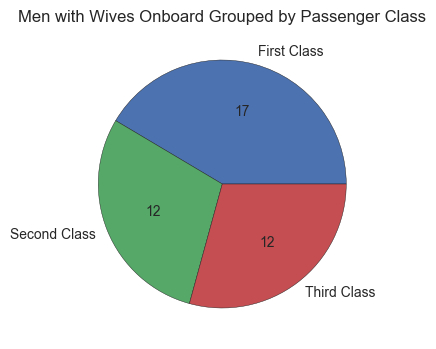

In [24]:
# split out men with Spouse: True and group by passenger class
marriedmales = slicedf(male_onesibsp_sp,'Spouse',True)

marriedmales_grp_class = marriedmales.groupby('Pclass')['Name'].count()

total = marriedmales_grp_class.sum()

# pie plot of husbands grouped by passenger class
marriedmales_grp_class.plot.pie(autopct=lambda(p): '{:.0f}'.format(p * total / 100), figsize=(4,4), 
                                labels = ['First Class','Second Class','Third Class'],
                                title='Men with Wives Onboard Grouped by Passenger Class')

plt.ylabel('')

When divided by passenger class, the groupings of men with wives onboard are around the same size.  This is ideal for our next comparison!

In [25]:
print "Survival Rates of Men with Wives Onboard Grouped by Passenger Class:"
print analyzevar(marriedmales,'Pclass')

print "\nMean Survival Rate across All Males Onboard:"
print male_tit_df['Survived'].mean()

Survival Rates of Men with Wives Onboard Grouped by Passenger Class:
   Pclass  Survival Rate
0       1       0.529412
1       2       0.083333
2       3       0.000000

Mean Survival Rate across All Males Onboard:
0.188908145581


The men with spouses in first class had a much much higher rate of survival than those in second or third.  The first class husband survival rate is nearly three times the mean survival rate across all men!  This is the most drastic difference across one variable seen in this analysis. 

Is the class differentiation as drastic in the females with spouses group?

In [26]:
# split out married women with Spouse: True and group by passenger class
marriedfemales = slicedf(marriedfem_sp,'Spouse',True)

print "Survival Rates of Females with Husbands Onboard Grouped by Pass Class:"
print analyzevar(marriedfemales,'Pclass')

print "\nMean Survival Rate across All Females Onboard:"
print fem_tit_df['Survived'].mean()

Survival Rates of Females with Husbands Onboard Grouped by Pass Class:
   Pclass  Survival Rate
0       1       1.000000
1       2       0.833333
2       3       0.500000

Mean Survival Rate across All Females Onboard:
0.742038216561


The differences in survival rates by class in the wives group is not as drastic as in the husbands group.  Both first and second class women with spouses onboard had average survival rates higher than the general female population on board.  

It is noteworthy that all of the first class females with spouses onboard survived!

### ---------------------------------------------------

In conclusion, by delving into passengers grouped by sibling/spouse count, it was seen that having a spouse onboard is only advantageous to first class passengers and to females in second class.  Second and third class husbands underperformed the overall male survival rate.  Also, traveling with larger numbers of close relatives (spouses/siblings) is a hindrance to survival - don't plan family reunions on cruises!

Some caveats to this study - this dataset only contains information for a little under half of the passengers/crew on board, so it is not comprehensive.  It is also noted in the data description that mistresses, fiances, and in-laws were excluded from the sib/sp count, so in reality the passengers investigated may have had greater numbers of immediate family/significant others onboard who were not recorded on their sib/sp count.

However, based on the subset of data analyzed here, being female, married with a spouse onboard, and in first class is the ideal survival profile.

Future detailed analysis could be performed on age, parent/child counts, ticket number, fare, cabin, and port of embarkment.  For instance, perhaps the married couples with children were less likely to survive than those without, because they would have prioritized getting their children to safety before themselves.